In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score

In [2]:
#---------------Handcrafted Adaline classifier-------------
class AdalineGD(object):
    """ADAptive LInear NEuron classifier.
    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.
    random_state : int
        The seed of the pseudo random number generator.
    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    errors_ : list
        Number of misclassifications in every epoch.
    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """ Fit training data.
        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples]
            Target values.
        Returns
        -------
        self : object
        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            output = self.activation(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return self.net_input(X)

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(X) >= 0.0, 1, -1)


In [3]:
#------------Load breast_cancer dataset-----------
init_data = load_breast_cancer()
(X, y) = load_breast_cancer(return_X_y=True)
X = pd.DataFrame(data=X, columns=init_data['feature_names'])
y = pd.DataFrame(data=y, columns=['label']).values.ravel()

In [5]:
#---------------Extract 2 features using PCA--------------
sc = StandardScaler()
Z = sc.fit_transform(X)

# Estimate the correlation matrix
R = np.dot(Z.T, Z) / X.shape[0]

#calculate the eigen values, eigen vectors
eigen_vals, eigen_vecs = np.linalg.eigh(R)

# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(reverse=True)

#select two features
#form the projection matrix
W_2D = np.hstack((eigen_pairs[0][1][:, np.newaxis],
                  eigen_pairs[1][1][:, np.newaxis]))

#final pca features
Z_pca = Z.dot(W_2D)
print(Z_pca)

[[ -9.19283683  -1.94858307]
 [ -2.3878018    3.76817174]
 [ -5.73389628   1.0751738 ]
 ..., 
 [ -1.25617928   1.90229671]
 [-10.37479406  -1.67201011]
 [  5.4752433    0.67063679]]


In [6]:
#--------------------Split training and testing data-----------------
X_train, X_test, y_train, y_test = train_test_split(Z_pca, y, test_size=0.3, random_state=0)

#initialize and train 
ada = AdalineGD(n_iter=50, eta=0.0001)
ada.fit(X_train, y_train)
    
y_pred = ada.predict(X_test)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % (accuracy_score(y_test, y_pred)))


Misclassified samples: 63
Accuracy: 0.63


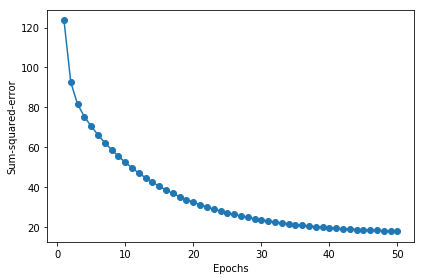

In [8]:
#----------Plot the costs against the number of epochs using this learning rate---------
plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')
plt.tight_layout()
plt.savefig('./output/Lab04-1.png', dpi=300)
plt.show()